4431872/4422102 [==============================] - 0s 0us/step


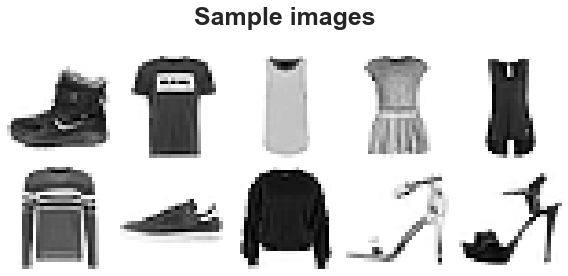

In [2]:
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("seaborn-white")

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

def display_images(data, title = "Sample images"):
    fig, axes = plt.subplots(2, 5, figsize=(8, 4))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(data[i])
        ax.axis("off")

    fig.suptitle(title, fontsize=25, fontweight="bold")
    fig.set_tight_layout("tight")

display_images(X_train)

## Preparing data

In [3]:
import tensorflow as tf

batch_size = 32
X_train = X_train.astype("float32")/255
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

<class 'method'>


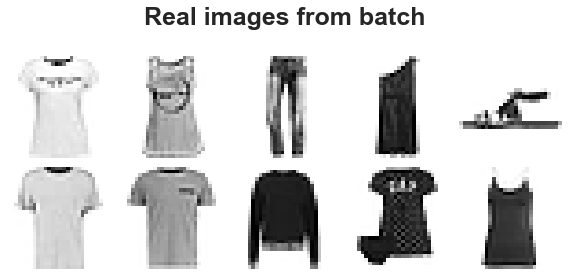

In [5]:
for data in dataset.take(1):
    print(type(data.numpy))
    display_images(data, "Real images from batch")

## Build model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.initializers import LecunNormal

In [11]:
coding_size = 30
image_shape = X_train[0].shape # (28x28)

generator = Sequential(
    [   # selu is scaled exponential linear unit
        Dense(100, activation="selu", kernel_initializer=LecunNormal()),
        Dense(150, activation="selu", kernel_initializer=LecunNormal()),
        Dense(image_shape[0] * image_shape[1], activation="sigmoid"),
        Reshape(image_shape),
    ]
)

discriminator = Sequential([
    Flatten(input_shape = image_shape),
    Dense(100, activation="selu", kernel_initializer=LecunNormal()),
    Dense(150, activation="selu", kernel_initializer=LecunNormal()),
    Dense(1, activation = "sigmoid")
])

gan = Sequential([generator, discriminator])

# we need to separately train discriminator and generator 
discriminator.compile(loss = "binary_crossentropy", optimizer = "rmsprop")

# trainable attribute taken into account only when compiling the model
# --> discriminator trainable when running discriminator.fit() or discriminator.train_on_batch()
# discriminators weights are frozen in gan model and is not trainable there
discriminator.trainable = False
gan.compile(loss = "binary_crossentropy", optimizer = "rmsprop")

## Train model

epoch=0
epoch=1
epoch=2


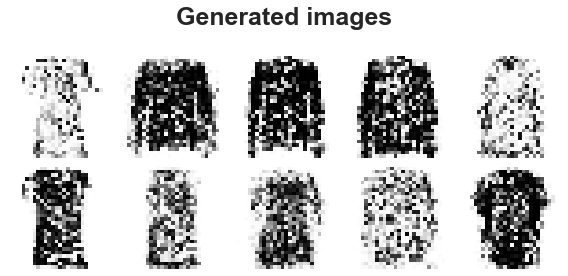

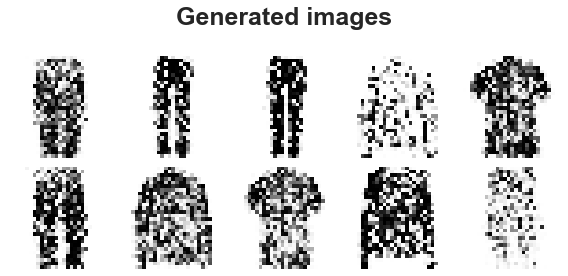

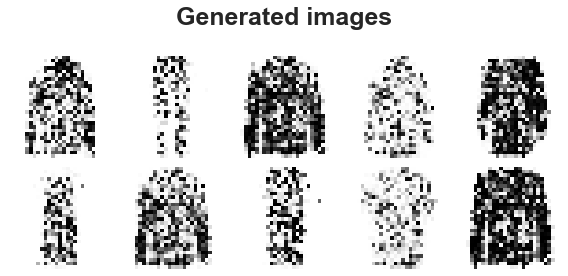

In [12]:
def train_gan(gan, dataset, batch_size, coding_size, n_epochs=50):
    generator, discriminator = gan.layers # 创建了两个layer

    for epoch in range(n_epochs):
        print(f"{epoch=}")
        for X_batch in dataset:
            # phase 1 - discriminator
            noise = tf.random.normal([batch_size, coding_size])
            generated_images = generator(noise)
            X_fake_real = tf.concat([generated_images, X_batch], axis=0)
            y_train1 = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)

            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_real, y_train1)

            # phase 2 - generator
            noise = tf.random.normal([batch_size, coding_size])
            y_train2 = tf.constant([[1.0]] * batch_size)

            # freeze the discriminator as we only want gradient signal from discriminator to generator
            discriminator.trainable = False
            gan.train_on_batch(noise, y_train2)

        display_images(generator(noise).numpy(), "Generated images")

train_gan(gan, dataset, batch_size, coding_size, 3)